# Versuch Overfitting zu erzwingen

In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)



from IPython.display import clear_output

In [2]:
from Channel_Modified import Static_Channel

# Defining the SBRNN

In [3]:
class SBRNN(nn.Module):
    def __init__(self, input_shape, num_lstm1, num_lstm2, num_dense1, num_dense2, training=True):
        super(SBRNN,self).__init__()
        self.inp_shape = input_shape
        self.outp_shape = (input_shape[0], input_shape[1], num_dense2)
        
        self.num_lstm1 = num_lstm1
        self.num_lstm2 = num_lstm2
        self.num_dense1 = num_dense1
        self.num_dense2 = num_dense2
        self.training = training
        self.init_hidden()
        self.last_window = False
        
        if self.training==False:
            #counter for correct averaging
            self.init_counter()
            #memory to store results of past predictions
            self.memory = np.zeros((self.inp_shape[0],self.inp_shape[1],num_dense2))
        
        
        #defining the layers
        #input has shape (sequ_len, batch, num_features)
        self.lstm1 = nn.LSTM(self.inp_shape[2], self.num_lstm1 ,num_layers=1, bidirectional=True)
        self.concat1 = nn.Linear(self.num_lstm1*2, self.num_lstm1)       #*2 bidirectional
        self.lstm2 = nn.LSTM(self.num_lstm1, self.num_lstm2, num_layers=1, bidirectional=True)
        self.concat2 = nn.Linear(self.num_lstm2*2, self.num_lstm2)       #*2 bidirectional
        self.dense1 = nn.Linear(self.num_lstm2, self.num_dense1)
        self.dense2 = nn.Linear(self.num_dense1, self.num_dense2)    
    
    def init_hidden(self, hidden1=None, hidden2=None):
        if hidden1==None and hidden2==None:
            #tuple of 2 tensors because LSTMs have a second state, which must be initialized
            #2 in 1st dimension, because of bidirectional LSTMs
            #                                batch_size            
            self.hidden1 = (torch.randn(2, self.inp_shape[1], self.num_lstm1), 
                            torch.randn(2, self.inp_shape[1], self.num_lstm1))
        
            self.hidden2 = (torch.randn(2, self.inp_shape[1], self.num_lstm2), 
                            torch.randn(2, self.inp_shape[1], self.num_lstm2))
        #if the hidden state is passed between different windows
        else:
            self.hidden1 = hidden1
            self.hidden2 = hidden2
        
    def init_counter(self):
        self.counter = 1
        self.last_window = False
        
    def forward(self,x):
        x, self.hidden1 = self.lstm1(x, self.hidden1)
        x = F.relu(self.concat1(x))
        x, self.hidden2 = self.lstm2(x, self.hidden2)
        x = F.relu(self.concat2(x))
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        
        if self.training == True:
            return x
        else:
            x = F.softmax(x, dim=2)
            x = self._average_outputs(x)
        return x
    
    #to be only used without training, gradient is lost
    def _average_outputs(self,x):
        self.memory += x.detach().numpy()

        if self.last_window == False:
            x = torch.from_numpy(self.memory[0,:,:])/float(self.counter)
            
            #reshaping x to always have the same dimensions
            x = x.reshape(-1,self.outp_shape[1], self.outp_shape[2])
           
            #shift one element to the left and fill with zeros
            self.memory = np.roll(self.memory, -1, axis=0)
            self.memory[-1,:,:] = np.zeros((self.inp_shape[1],num_dense2))
            #to correctly normalize the outputs in the first window
            if self.counter < self.inp_shape[0]:
                self.counter += 1
            
            
        elif self.last_window == True:
            for i in range(self.inp_shape[0]):
                self.memory[i,:,:] = self.memory[i,:,:]/self.counter
                if i>= self.inp_shape[0]-self.counter:
                    self.counter -= 1
            x = torch.from_numpy(self.memory)
        
        return x

In [4]:
#defining the parameters
save_path = "pytorch_model.pt"
sequ_length = 1000

#defining the hyperparameters
oversampling_factor = 5
batch_size = 32
window_size = 50
num_lstm1 = 512
num_lstm2 = 256
num_dense1 = 128
num_dense2 = 2
num_epochs = 15

snr_upper = 30
snr_lower = 25
snr_step = 0.5

input_shape = (window_size, batch_size, oversampling_factor)

### Target Correction
The model needs to get its targets as a class number starting from 0. The -1s and 1s are renumbered here.

In [5]:
def binary_target_correction(ybatch):
        y_binary = np.array([[0 if j==-1 else 1 for j in i] for i in ybatch])        
        return y_binary
    
        

### Quantization
It is easier for the model to incrementally learn a task. Therefore the quantization gradually gets more coarse throughout the training. The digitize()-function is responsible for the quantization and normalization of the received data.

In [6]:
def digitize(sequence, high, low, bits):
    bins = np.linspace(low, high, 2**bits)
    for i in range(len(sequence)):
        bin_index = np.argmin(np.abs(bins-sequence[i]))
        sequence[i] = bins[bin_index]
    sequence = sequence/high
    
    return sequence

Test whether the digitize() functions gives the same result as before

In [7]:
hc_a = [(0.1,0),(0.25,1),(0.16,2),(0.08,3),(0.04,4)]
maximum = sum([x[0] for x in hc_a])
minimum = -maximum
channel = Static_Channel(len(hc_a), hc_a, "rc", oversampling_factor=oversampling_factor)
channel.set_snr(100)
data = np.zeros((1000, oversampling_factor))
targets = np.random.choice([-1,1], 1000)

channel.transmit(targets)
data = channel.receive()

data_dig = data.copy()
data_dig[data_dig < 0] = -1
data_dig[data_dig > 0] = 1

data = digitize(data, maximum, minimum, 1)
print(np.count_nonzero(data_dig-data))



0


Yay, the function works!

In [8]:
def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(int(x / 10))
    return s

# The Training Loop

average training loss:  0.07075792629271746 , loss during test:  0.4705283 , resolution:  1  bits


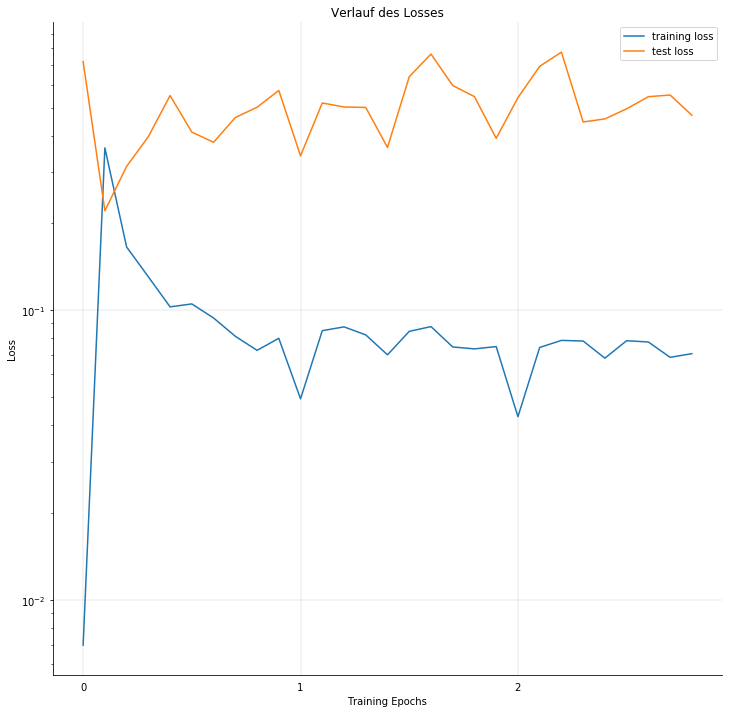

KeyboardInterrupt: 

In [9]:
sbrnn = SBRNN(input_shape, num_lstm1, num_lstm2, num_dense1, num_dense2)
hc_a = [(0.1,0),(0.25,1),(0.16,2),(0.08,3),(0.04,4)]
maximum = sum([x[0] for x in hc_a])
minimum = -maximum
channel = Static_Channel(len(hc_a), hc_a, "rc", oversampling_factor=oversampling_factor)
channel.set_snr(50)
optimizer = optim.Adam(sbrnn.parameters(),lr=0.01)
loss_function = nn.CrossEntropyLoss()
cumulative_loss = 0
loss_list = [[],[],[],[]]



train_data = np.zeros((sequ_length, batch_size, oversampling_factor))
train_targets = np.random.choice([-1,1], (sequ_length, batch_size, 1))
for i in range(batch_size):
    channel.transmit(train_targets[:,i,0])
    train_data[:,i,:] = digitize(channel.receive(),maximum, minimum, 1).reshape(sequ_length,oversampling_factor)
train_targets = binary_target_correction(train_targets)
train_data = train_data.astype("float32")
train_targets = train_targets.astype("int64")
    
test_data = np.zeros((window_size, batch_size, oversampling_factor))
test_targets = np.random.choice([-1,1], (window_size, batch_size, 1))
for i in range(batch_size):
    channel.transmit(test_targets[:,i])
    test_data[:,i,:] = digitize(channel.receive(), maximum, minimum,2).reshape(window_size,oversampling_factor)
test_targets = binary_target_correction(test_targets)
test_data = test_data.astype("float32")
test_targets = test_targets.astype("int64")

for epoch in range(num_epochs):
    num_windows = sequ_length - window_size + 1
    for i in range(num_windows):
        winY = train_targets[i:i+window_size,:]
        winX = train_data[i:i+window_size,:,:]
        
        winY = torch.from_numpy(winY)
        winX = torch.from_numpy(winX)

        output = sbrnn(winX)
        output = output.view(-1,2)
        winY = winY.view(-1)
        
        hidden1_temp = (sbrnn.hidden1[0].detach(), sbrnn.hidden1[1].detach())
        hidden2_temp = (sbrnn.hidden2[0].detach(), sbrnn.hidden2[1].detach())
        sbrnn.init_hidden(hidden1_temp, hidden2_temp)

        loss = loss_function(output, winY)
        optimizer.zero_grad()
        sbrnn.init_hidden()
        loss.backward()
        optimizer.step()
        cumulative_loss += loss.detach().numpy()

        #estimate the performance with one test window every 100 windows
        if i % 100 == 0:
            test_winX = torch.from_numpy(test_data)
            test_winY = torch.from_numpy(test_targets)
            sbrnn.init_hidden()
            test_output = sbrnn(test_winX)
            test_output = test_output.view(-1,2)
            test_winY = test_winY.view(-1)

            test_loss = loss_function(test_output, test_winY).detach().numpy()
            sbrnn.init_hidden(hidden1_temp, hidden2_temp)
            clear_output()
            print("average training loss: ", cumulative_loss/100, 
                  ", loss during test: ", test_loss, ", resolution: ", 1, " bits")
            loss_list[2].append(cumulative_loss/100)
            loss_list[3].append(test_loss)
            loss_list[0].append(epoch)
            cumulative_loss = 0
            
            xfmt = tkr.FuncFormatter(numfmt)
            fig, ax = plt.subplots(figsize=(12,12))
            ax.set_title("Verlauf des Losses")
            ax.set_ylabel("Loss")
            ax.set_xlabel("Training Epochs")
            ax.xaxis.set_major_locator(MultipleLocator(10))
            ax.tick_params(axis='x', which='major', bottom=False)
            ax.xaxis.set_major_formatter(xfmt)
            
            ax.set_yscale("log")
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.7)
            ax.plot(loss_list[2], label="training loss")
            ax.plot(loss_list[3], label="test loss")
            plt.legend()
            plt.show()
            

                

df = pd.DataFrame({"epoch": loss_list[0],
                   "snr": loss_list[1],
                   "training_loss": loss_list[2],
                   "test_loss": loss_list[3]})
df.to_csv("training_results.csv")